In [188]:
import pathlib

path=str(pathlib.Path().resolve())+"/"

In [189]:
import pandas as pd


wine = pd.read_csv(path+"winequality-red.csv")

In [190]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [191]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [192]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [193]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

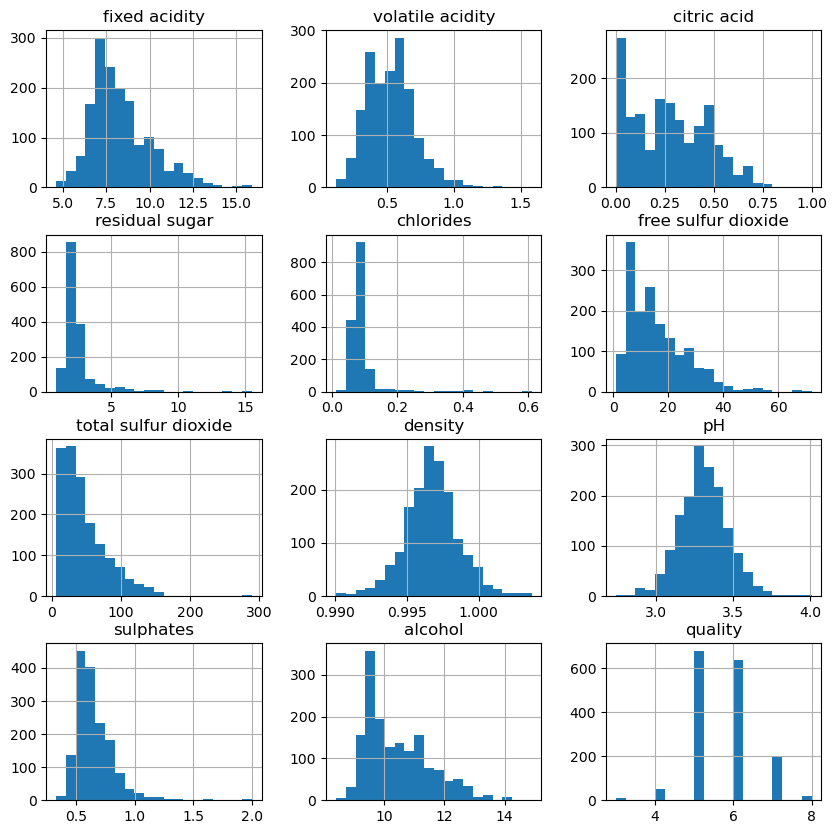

In [194]:
wine.hist(bins=20,figsize=(10,10))

<Axes: xlabel='alcohol', ylabel='volatile acidity'>

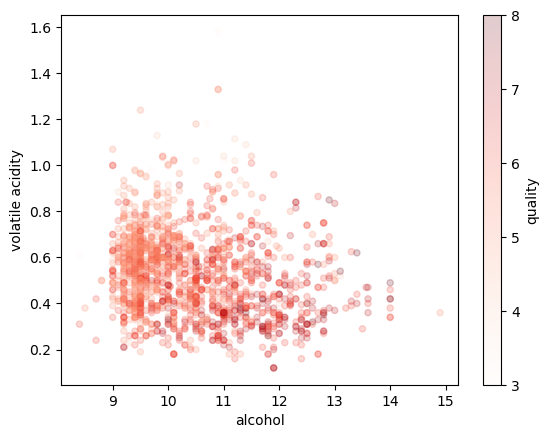

In [195]:
# Vemos que los que tienen más calidad en su mayoría rondan un nivel medio de Alcohol y un nivel Medio-Bajo de cítrico
wine.plot.scatter(y="volatile acidity",x="alcohol",alpha=0.2,c="quality",cmap="Reds")

# Boxplots para cada columna, desglosada por calidad

In [196]:
from pathlib import Path
import sys


pathA=Path(path).parent.parent.parent.parent.parent
sys.path.insert(0,str(pathA))

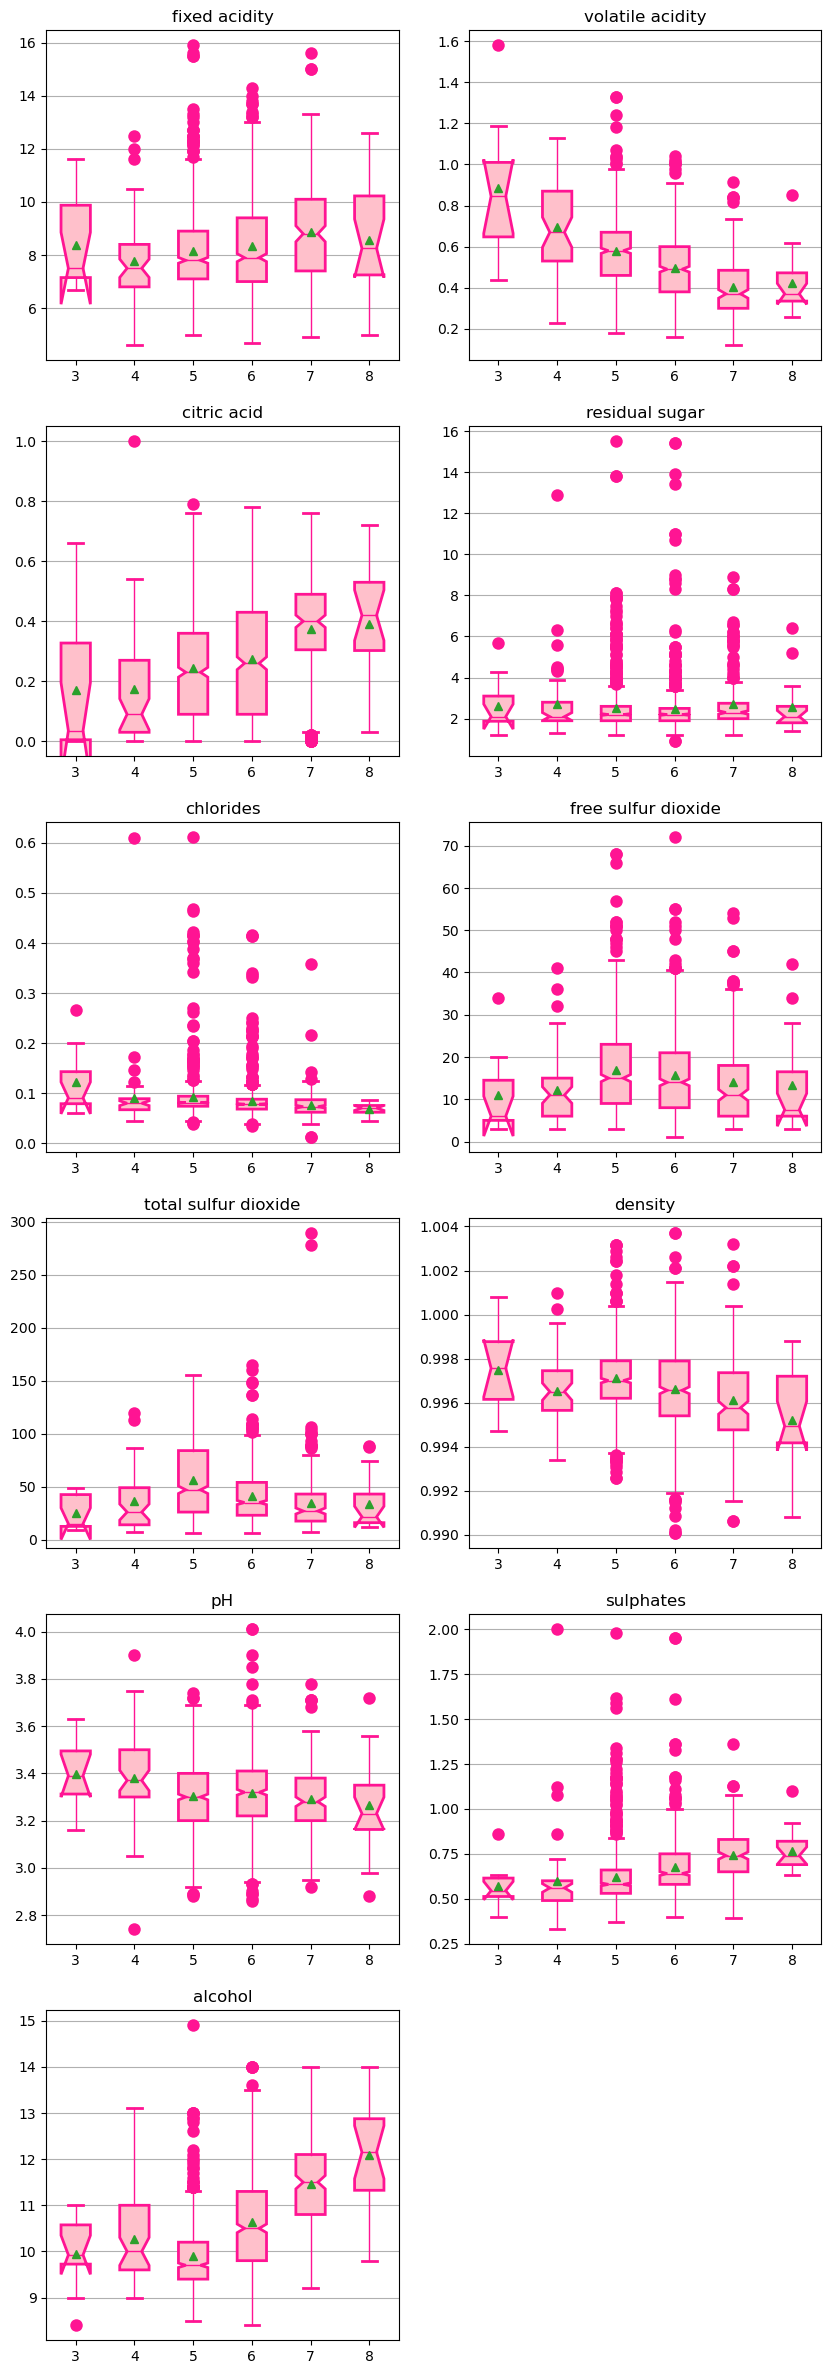

In [197]:
from matplotlib import pyplot as plt

from IA.Clases.Matplot.BoxPlot import BoxPlot


BoxPlot.box_plot(types=wine.columns,by="quality",dataFrame=wine,deepColor="deeppink",faceColor="Pink",color="Pink",ballsColor="deeppink")


**Matriz de correlación y mapa de calor**

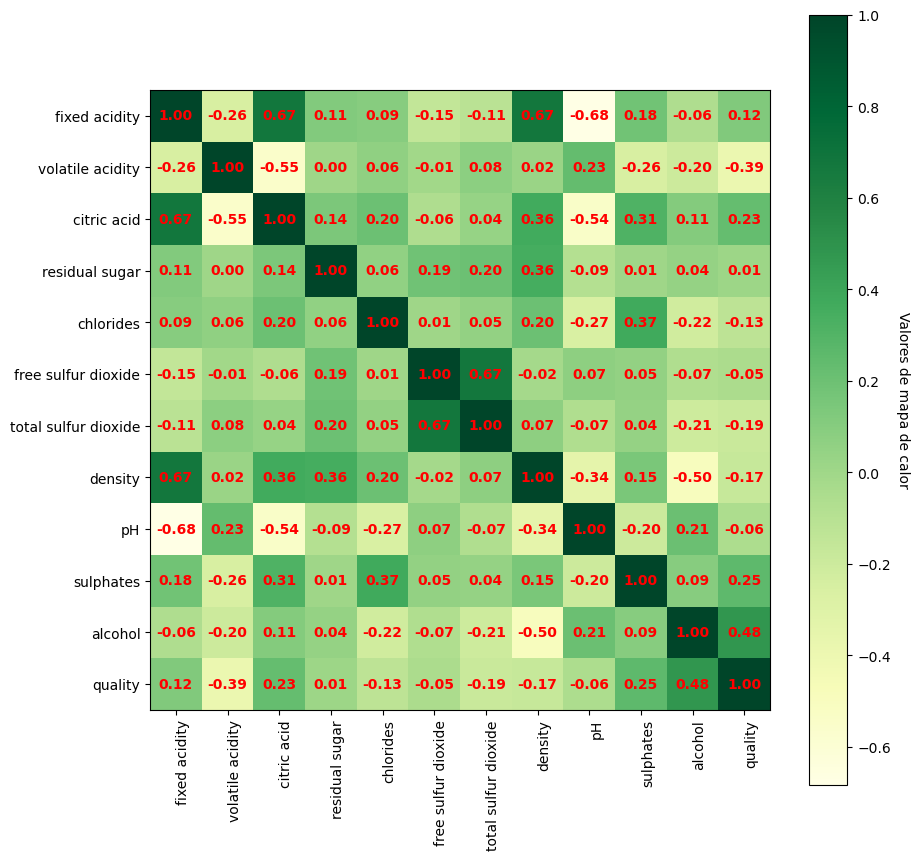

In [198]:
from IA.Clases.Matplot.HeatMap import HeatMap


corr_matrix = wine.corr()
HeatMap.heat_map(corr_matrix,corr_matrix.columns,corr_matrix,corr_matrix.columns,corr_matrix.columns,cmap="YlGn",figsize=(10,10),weight="bold",textColor="red")

array([[<Axes: xlabel='quality', ylabel='quality'>,
        <Axes: xlabel='alcohol', ylabel='quality'>,
        <Axes: xlabel='sulphates', ylabel='quality'>,
        <Axes: xlabel='pH', ylabel='quality'>,
        <Axes: xlabel='free sulfur dioxide', ylabel='quality'>,
        <Axes: xlabel='chlorides', ylabel='quality'>,
        <Axes: xlabel='residual sugar', ylabel='quality'>,
        <Axes: xlabel='citric acid', ylabel='quality'>,
        <Axes: xlabel='fixed acidity', ylabel='quality'>],
       [<Axes: xlabel='quality', ylabel='alcohol'>,
        <Axes: xlabel='alcohol', ylabel='alcohol'>,
        <Axes: xlabel='sulphates', ylabel='alcohol'>,
        <Axes: xlabel='pH', ylabel='alcohol'>,
        <Axes: xlabel='free sulfur dioxide', ylabel='alcohol'>,
        <Axes: xlabel='chlorides', ylabel='alcohol'>,
        <Axes: xlabel='residual sugar', ylabel='alcohol'>,
        <Axes: xlabel='citric acid', ylabel='alcohol'>,
        <Axes: xlabel='fixed acidity', ylabel='alcohol'>],
      

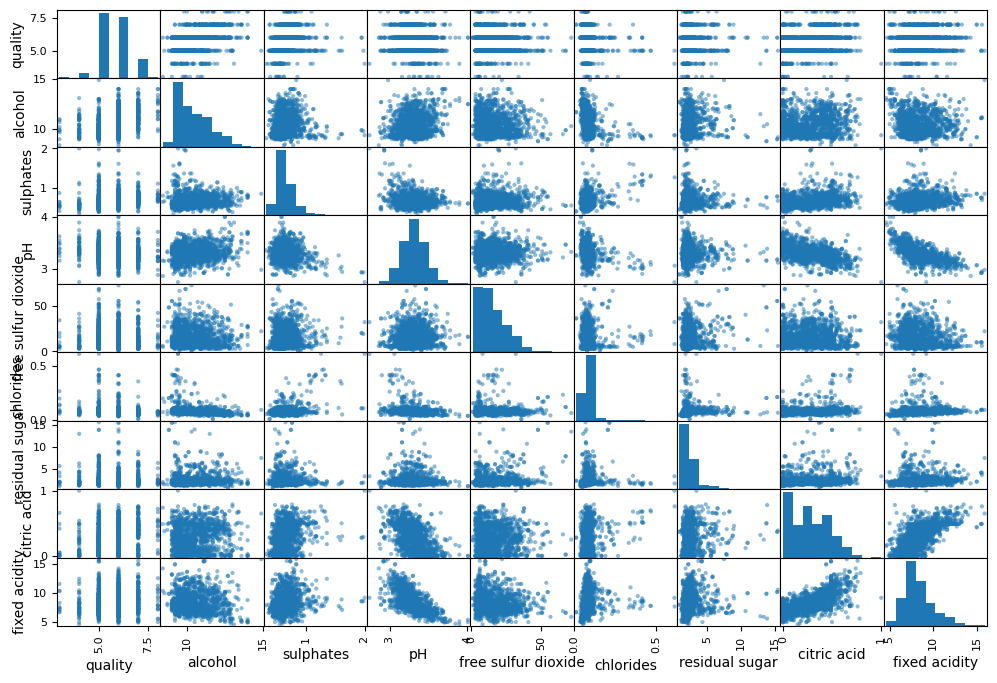

In [199]:
from pandas.plotting import scatter_matrix
columns = ["quality","alcohol","sulphates","pH","free sulfur dioxide","chlorides","residual sugar","citric acid","fixed acidity"]
scatter_matrix(wine[columns], figsize=(12,8))

# **Limpieza**

In [200]:
import numpy as np
wine["quality_cat"] = pd.cut(wine["quality"],
                             bins=[0.0, 1.5, 3, 4.5, 6, np.inf],
                             labels=[1,2,3,4,5])



In [201]:
wine=wine.drop(wine[wine['total sulfur dioxide']>200].index,axis=0)

In [202]:
wine=wine.drop(wine[wine['chlorides']>0.4].index,axis=0)

In [203]:
wine=wine.drop(wine[wine['alcohol']>=14].index,axis=0)

# **Modelo**

In [204]:
def split_train_test(data,test_ratio):
    # indices = [i for i in range(len(data))]; indices = np.shuffle(.....)
  # NOS DA UNA LSITA BARAJADA
  indices = np.random.permutation(len(data))
  # LE DECIMOS CUANTO TEST SE USARÁ
  lg_test = int(len(data) * test_ratio)
  # SE REPARTEN
  test_indices = indices[:lg_test]
  train_indices = indices[lg_test:]
  # Y SE DEVUELVE UNA TABLA DE ENTRENAMIENTO Y OTRA DE TEST
  return data.iloc[train_indices], data.iloc[test_indices]

In [205]:
np.random.seed(42)
dt_train,dt_test = split_train_test(wine,0.2)

In [206]:
#dataFrame = dt_train.loc[:,columns]

y_train = dt_train["quality"].copy()
x_train = dt_train.drop(["quality"],axis=1)

#y_train = dataFrame["quality"].copy()
#x_train = dataFrame.drop(["quality"],axis=1)

In [207]:
x_train.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
1058,9.9,0.53,0.57,2.4,0.093,30.0,52.0,0.99710,3.19,0.76,11.6,5
284,9.9,0.59,0.07,3.4,0.102,32.0,71.0,1.00015,3.31,0.71,9.8,4
1242,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2,4


In [208]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

# MÓDELO CREADO

LinearRegression()

In [209]:
datos_prueba =  x_train[:10]
print("PREDICCIONES: ",lin_reg.predict(datos_prueba))
y_reales = y_train[:10]
print("Reales: ", list(y_reales))

PREDICCIONES:  [7.02363934 5.4657305  5.83840474 7.03060001 5.6464773  5.21700911
 5.71989422 5.38320317 5.71387964 7.00915908]
Reales:  [7, 5, 6, 7, 6, 6, 5, 5, 6, 8]


In [210]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

predicciones = lin_reg.predict(x_train)
mse = mean_squared_error(y_train, predicciones)
mse = np.sqrt(mse)
mae = mean_absolute_error(y_train, predicciones)
score = r2_score(y_train, predicciones)
# No lo realiza tan mal
print(f"mae(ERROR MEDIO ABSOLUTO): {mae}   mse(ERROR CUADRÁTICO): {mse}  score:{score}")

mae(ERROR MEDIO ABSOLUTO): 0.36073792856461856   mse(ERROR CUADRÁTICO): 0.4135964394192913  score:0.7333053883438043
